In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.7 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, GlobalMaxPool1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertTokenizer
from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization

In [4]:
data = pd.read_csv("task2.csv")

In [5]:
data['nlabel'].unique()

array([False,  True])

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
tokens = []
for text in data["Generation"]:
  tokens.append(tokenizer.tokenize(text))

In [8]:
token_ids = []
for token in tokens:
  token_ids.append(tokenizer.convert_tokens_to_ids(token))

In [9]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Tokenize the text into words and sentences
feature = []
for corpus in data["Generation"]:
  words = word_tokenize(corpus)
  sentences = sent_tokenize(corpus)
  word_lengths = [len(w) for w in words if w not in stopwords.words('english')]
  avg_word_length = sum(word_lengths) / len(word_lengths)
  avg_sentence_length = len(words) / len(sentences)
  vocab = set(words)
  vocab_size = len(vocab)
  lexical_diversity = len(words) / vocab_size
  pos_tags = nltk.pos_tag(words)
  noun_count = len([w for w, pos in pos_tags if pos.startswith('NN')])
  verb_count = len([w for w, pos in pos_tags if pos.startswith('VB')])
  adj_count = len([w for w, pos in pos_tags if pos.startswith('JJ')])
  feature.append([avg_word_length, avg_sentence_length, vocab_size, lexical_diversity, noun_count, verb_count, adj_count])

In [10]:
maxlen = 100
padded_sequences = pad_sequences(token_ids, maxlen=maxlen)

In [11]:
feat = np.array(feature)

In [12]:
padd = np.concatenate([padded_sequences, feat], axis = 1)

In [13]:
labels = pd.get_dummies(data["nlabel"]).values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(padd, labels, test_size=0.2, stratify = labels)

In [15]:
y_test = np.argmax(y_test, axis=1)

In [20]:
model = Sequential()
model.add(Embedding(tokenizer.vocab_size + 8, 128, input_length=maxlen + 7))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation="softmax"))


# compile and train the model
batch_size = 64
epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
118/118 [==============================] - 37s 239ms/step - loss: 0.2502 - accuracy: 0.9080 - val_loss: 0.3969 - val_accuracy: 0.9451
Epoch 2/30
118/118 [==============================] - 20s 174ms/step - loss: 0.0907 - accuracy: 0.9659 - val_loss: 0.1914 - val_accuracy: 0.9494
Epoch 3/30
118/118 [==============================] - 17s 145ms/step - loss: 0.0371 - accuracy: 0.9887 - val_loss: 0.1389 - val_accuracy: 0.9483
Epoch 4/30
118/118 [==============================] - 14s 120ms/step - loss: 0.0246 - accuracy: 0.9913 - val_loss: 0.1406 - val_accuracy: 0.9355
Epoch 5/30
118/118 [==============================] - 13s 112ms/step - loss: 0.0153 - accuracy: 0.9943 - val_loss: 0.1286 - val_accuracy: 0.9558
Epoch 6/30
118/118 [==============================] - 11s 93ms/step - loss: 0.0056 - accuracy: 0.9980 - val_loss: 0.1841 - val_accuracy: 0.9504
Epoch 7/30
118/118 [==============================] - 11s 92ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.2693 - val_accu

In [21]:
y_pred02 = model.predict(X_test)
y_pred02 = np.argmax(y_pred02, axis=1)

74/74 [==============================] - 4s 14ms/step


In [22]:
print(classification_report(y_test, y_pred02))
print(confusion_matrix(y_test, y_pred02))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2133
           1       0.77      0.69      0.73       213

    accuracy                           0.95      2346
   macro avg       0.87      0.83      0.85      2346
weighted avg       0.95      0.95      0.95      2346

[[2090   43]
 [  67  146]]


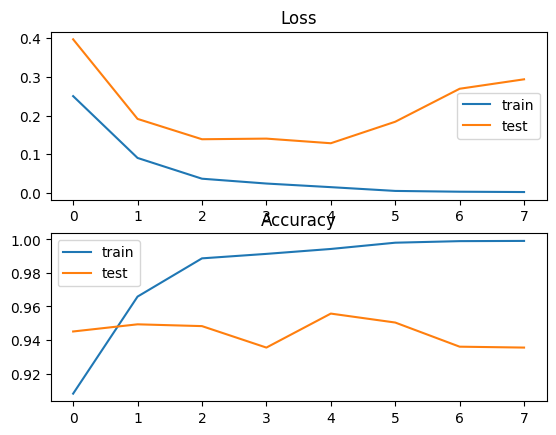

In [23]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()